<a href="https://colab.research.google.com/github/sreesriavvaru123/MI/blob/main/MI_CNN_LSTM_v11_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab-compatible notebook for MI detection using PTB-XL with 12-leads and 10-fold CV



## STEP 1: Install necessary packages



In [ ]:
!pip install wfdb scikit-learn matplotlib tensorflow --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 127.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


## STEP 2: Import required libraries


In [ ]:
# CNN-LSTM with Stacking Decoding on PTB-XL (MI, Healthy, Other) - 12-lead Version
# Step 2: Imports
import os
import numpy as np
import pandas as pd
import wfdb
from tqdm import tqdm
from scipy.signal import savgol_filter, resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout, LSTM, Dense
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## STEP 3: Download and unzip PTB-XL data

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI if not already
!pip install -q kaggle

# Download the PTB-XL dataset
!kaggle datasets download -d khyeh0719/ptb-xl-dataset

# Unzip the dataset
!unzip ptb-xl-dataset.zip -d ptb-xl


Streaming output truncated to the last 5000 lines.
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/1934

## STEP 4: Load metadata and diagnostic class mapping

In [ ]:
import pandas as pd

ptbxl_path = "/content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"
print("Loading metadata...")

# Load metadata and SCP diagnostic info
df = pd.read_csv(ptbxl_path + 'ptbxl_database.csv')
class_map = pd.read_csv(ptbxl_path + 'scp_statements.csv', index_col=0)

# Add full path to 100Hz signal files
df['filename_lr'] = ptbxl_path + df['filename_lr']

# Evaluate stringified dict to real dict
df['scp_codes'] = df['scp_codes'].apply(eval)

# Define mapping from SCP codes to 3 classes
def map_3_classes(scp_codes, class_map):
    """
    Maps SCP codes to 3 classes: MI, NORM, OTHER.
    """
    mi_codes = class_map[class_map['diagnostic_class'] == 'MI'].index.tolist()
    norm_codes = class_map[class_map['diagnostic_class'] == 'NORM'].index.tolist()

    for code in scp_codes.keys():
        if code in mi_codes:
            return 'MI'
        if code in norm_codes:
            return 'NORM'

    # If no MI or NORM code is found, return 'OTHER'
    return 'OTHER'

# Apply 3-class mapping
df['class'] = df['scp_codes'].apply(lambda x: map_3_classes(x, class_map))

# Drop rows with unmapped class
df = df[df['class'].notnull()]

# Display class distribution
print("Class distribution:")
print(df['class'].value_counts())

# Final usable dataset
df_multiclass = df[['filename_lr', 'class']]

Loading metadata...
Class distribution:
class
NORM     9528
OTHER    6824
MI       5485
Name: count, dtype: int64


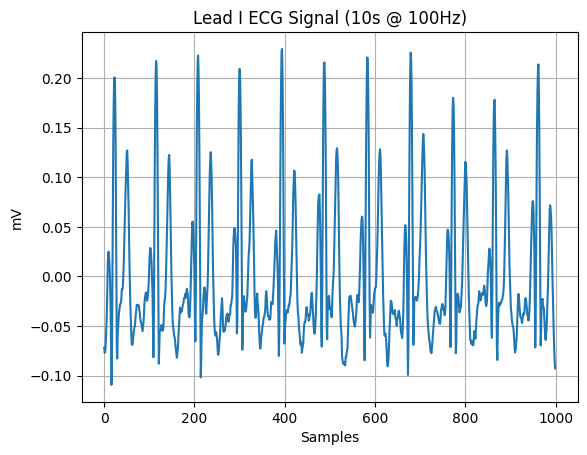

In [ ]:
# Step 4: Signal Processing Function

def preprocess_ecg(record_path):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal.T  # Shape (12, 5000)

    # Denoising (per lead)
    signal_denoised = savgol_filter(signal, window_length=13, polyorder=3, axis=1)
    baseline = savgol_filter(signal_denoised, window_length=301, polyorder=4, axis=1)
    signal_clean = signal_denoised - baseline

    # Downsample from 500Hz to 250Hz
    # signal_downsampled = resample(signal_clean, 1000, axis=1)  # Direct to fixed 250Hz * 10s = 2500 samples
    return signal_clean

import matplotlib.pyplot as plt

test_ecg = preprocess_ecg(df_multiclass['filename_lr'].values[0].replace('.hea', ''))
plt.plot(test_ecg[0])  # Plot lead I
plt.title("Lead I ECG Signal (10s @ 100Hz)")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.grid(True)
plt.show()

# Step 5: Create Dataset

def create_dataset(df, max_per_class=None):
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle
    X, y = [], []
    counts = {"MI": 0, "NORM": 0, "OTHER": 0}
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        label = row["class"]
        if max_per_class and counts[label] >= max_per_class:
            continue
        path = row["filename_lr"].replace(".hea", "")  # Remove .hea extension
        try:
            ecg = preprocess_ecg(path)
            if ecg.shape != (12, 1000):
                print(f"Skipping {path} due to incorrect shape {ecg.shape}")
                continue
            X.append(ecg)
            y.append(["MI", "NORM", "OTHER"].index(label))
            counts[label] += 1
        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue
    print("Final class counts:", counts)
    X = np.array(X)
    y = to_categorical(y, num_classes=3)
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    return X, y


In [ ]:
# Unbalanced
print("Creating unbalanced dataset...")
X_unbal, y_unbal = create_dataset(df_multiclass)

# Balanced
print("Creating balanced dataset...")
X_bal, y_bal = create_dataset(df_multiclass, max_per_class=5000)

Creating unbalanced dataset...


100%|██████████| 21837/21837 [02:25<00:00, 149.94it/s]


Final class counts: {'MI': 5485, 'NORM': 9528, 'OTHER': 6824}
X shape: (21837, 12, 1000)
y shape: (21837, 3)
Creating balanced dataset...


100%|██████████| 21837/21837 [01:54<00:00, 189.96it/s] 


Final class counts: {'MI': 5000, 'NORM': 5000, 'OTHER': 5000}
X shape: (15000, 12, 1000)
y shape: (15000, 3)


In [ ]:
# First: Train+Val (80%) and Test (20%)
# Step 7: Split 60/20/20
X = np.transpose(X_bal, (0, 2, 1))
y = y_bal
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42)

# Then: Train (60%) and Val (20%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp.argmax(axis=1), random_state=42)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (9000, 1000, 12)
Validation shape: (3000, 1000, 12)
Test shape: (3000, 1000, 12)


In [ ]:
print(y_train)
y_train_3classes = df['class']
print(y_train_3classes)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
0         NORM
1         NORM
2         NORM
3         NORM
4         NORM
         ...  
21832    OTHER
21833     NORM
21834    OTHER
21835     NORM
21836     NORM
Name: class, Length: 21837, dtype: object


In [14]:
# === CNN-LSTM BINARY CLASSIFIER ===
def create_binary_model():
    input_layer = Input(shape=(1000, 12))  # 12-lead ECG, 1000 samples
    x = Conv1D(32, 5, activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.5)(x)

    x = Conv1D(32, 5, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.5)(x)

    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def get_meta_features(models, X):
    features = []
    for model in models:
        pred = model.predict(X, verbose=0)
        features.append(pred)
    return np.concatenate(features, axis=1)  # shape: (samples, 6)

# === META CLASSIFIER ===
def create_meta_model(num_classes=3):
    model = Sequential([
        Input(shape=(6,)),
        Dense(64, activation='tanh'),
        Dense(32, activation='tanh'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def prepare_binary_dataset(X, y, class_a, class_b):
    idx = np.where((y == class_a) | (y == class_b))[0]
    X_bin = X[idx]
    y_bin = y[idx]
    y_bin = np.where(y_bin == class_a, 0, 1)  # class_a → 0, class_b → 1
    y_bin = to_categorical(y_bin, 2)
    return X_bin, y_bin

def get_meta_features(models, X):
    features = [model.predict(X, verbose=0) for model in models]
    return np.concatenate(features, axis=1)  # shape: (samples, 6)

model = create_meta_model(num_classes=3)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,627 (10.26 KB)

 Trainable params: 2,627 (10.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def prepare_binary_dataset(X, y_onehot, class_a, class_b):
    """
    Extracts a binary dataset from the full one-hot encoded dataset.

    Parameters:
        X: Input samples, shape (N, 1000, 12)
        y_onehot: One-hot labels, shape (N, 3)
        class_a, class_b: The two class indices to compare (e.g., 0 and 2)

    Returns:
        X_binary: Filtered inputs for the 2 classes
        y_binary: One-hot encoded binary labels (N, 2)
    """
    # Convert one-hot → class index (e.g., 0, 1, 2)
    y_class = np.argmax(y_onehot, axis=1)

    # Get only samples of class_a or class_b
    idx = np.where((y_class == class_a) | (y_class == class_b))[0]
    X_bin = X[idx]
    y_bin = y_class[idx]

    # Relabel: class_a → 0, class_b → 1
    y_bin = np.where(y_bin == class_a, 0, 1)

    # Convert to binary one-hot encoding
    y_bin = to_categorical(y_bin, 2)

    return X_bin, y_bin


In [ ]:
# Train Binary Classifiers
# Binary 1: AFIB (0) vs OTHER (2)
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model1.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)
X1, y1 = prepare_binary_dataset(X_train, y_train, 0, 2)
model1 = create_binary_model()
model1.fit(X1, y1, epochs=20, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

# Binary 2: NORM (1) vs OTHER (2)
checkpoint = ModelCheckpoint(
    'best_model2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)
X2, y2 = prepare_binary_dataset(X_train, y_train, 1, 2)
model2 = create_binary_model()
model2.fit(X2, y2, epochs=20, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

# Binary 3: AFIB (0) vs NORM (1)
checkpoint = ModelCheckpoint(
    'best_model3.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)
X3, y3 = prepare_binary_dataset(X_train, y_train, 0, 1)
model3 = create_binary_model()
model3.fit(X3, y3, epochs=20, batch_size=32, validation_split=0.2, callbacks=[checkpoint])


Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5595 - loss: 0.6835
Epoch 1: val_accuracy improved from -inf to 0.51083, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 179ms/step - accuracy: 0.5597 - loss: 0.6834 - val_accuracy: 0.5108 - val_loss: 0.7254
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6405 - loss: 0.6396
Epoch 2: val_accuracy improved from 0.51083 to 0.57667, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 176ms/step - accuracy: 0.6406 - loss: 0.6396 - val_accuracy: 0.5767 - val_loss: 0.7252
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6764 - loss: 0.6185
Epoch 3: val_accuracy improved from 0.57667 to 0.64167, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.6764 - loss: 0.6185 - val_accuracy: 0.6417 - val_loss: 0.6712
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6919 - loss: 0.6080
Epoch 4: val_accuracy did not improve from 0.64167
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.6919 - loss: 0.6080 - val_accuracy: 0.6242 - val_loss: 0.6789
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6628 - loss: 0.6095
Epoch 5: val_accuracy improved from 0.64167 to 0.68750, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.6629 - loss: 0.6096 - val_accuracy: 0.6875 - val_loss: 0.6150
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7115 - loss: 0.5908
Epoch 6: val_accuracy improved from 0.68750 to 0.69833, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.7114 - loss: 0.5908 - val_accuracy: 0.6983 - val_loss: 0.5955
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7097 - loss: 0.5940
Epoch 7: val_accuracy improved from 0.69833 to 0.70917, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - accuracy: 0.7097 - loss: 0.5939 - val_accuracy: 0.7092 - val_loss: 0.5788
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7090 - loss: 0.5743
Epoch 8: val_accuracy did not improve from 0.70917
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 177ms/step - accuracy: 0.7090 - loss: 0.5743 - val_accuracy: 0.6783 - val_loss: 0.6709
Epoch 9/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7252 - loss: 0.5464
Epoch 9: val_accuracy improved from 0.70917 to 0.71750, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.7252 - loss: 0.5466 - val_accuracy: 0.7175 - val_loss: 0.5675
Epoch 10/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7274 - loss: 0.5640
Epoch 10: val_accuracy improved from 0.71750 to 0.72500, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.7274 - loss: 0.5639 - val_accuracy: 0.7250 - val_loss: 0.5697
Epoch 11/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7216 - loss: 0.5521
Epoch 11: val_accuracy did not improve from 0.72500
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.7215 - loss: 0.5522 - val_accuracy: 0.7133 - val_loss: 0.5734
Epoch 12/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7231 - loss: 0.5608
Epoch 12: val_accuracy improved from 0.72500 to 0.73083, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.7231 - loss: 0.5608 - val_accuracy: 0.7308 - val_loss: 0.5611
Epoch 13/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7440 - loss: 0.5472
Epoch 13: val_accuracy did not improve from 0.73083
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.7440 - loss: 0.5473 - val_accuracy: 0.7133 - val_loss: 0.6022
Epoch 14/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7412 - loss: 0.5461
Epoch 14: val_accuracy did not improve from 0.73083
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.7412 - loss: 0.5461 - val_accuracy: 0.7158 - val_loss: 0.5806
Epoch 15/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7416 - loss: 0.5536
Epoch 15: val_accuracy did not improve from 0.73083
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.7416 - loss: 0.5535 - val_accuracy: 0.7308 - val_loss: 0.6364
Epoch 16/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7579 - loss: 0.5284
Epoch 16

150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 177ms/step - accuracy: 0.7406 - loss: 0.5319 - val_accuracy: 0.7533 - val_loss: 0.5360
Epoch 20/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7531 - loss: 0.5329
Epoch 20: val_accuracy improved from 0.75333 to 0.75500, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.7531 - loss: 0.5329 - val_accuracy: 0.7550 - val_loss: 0.5535
Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7091 - loss: 0.5639
Epoch 1: val_accuracy improved from -inf to 0.51000, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 179ms/step - accuracy: 0.7095 - loss: 0.5635 - val_accuracy: 0.5100 - val_loss: 1.1841
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8031 - loss: 0.4491
Epoch 2: val_accuracy improved from 0.51000 to 0.51750, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.8032 - loss: 0.4490 - val_accuracy: 0.5175 - val_loss: 1.1861
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8312 - loss: 0.4067
Epoch 3: val_accuracy improved from 0.51750 to 0.62000, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.8312 - loss: 0.4067 - val_accuracy: 0.6200 - val_loss: 1.1167
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8330 - loss: 0.4108
Epoch 4: val_accuracy improved from 0.62000 to 0.82333, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - accuracy: 0.8330 - loss: 0.4107 - val_accuracy: 0.8233 - val_loss: 0.4530
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8330 - loss: 0.3873
Epoch 5: val_accuracy did not improve from 0.82333
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 183ms/step - accuracy: 0.8330 - loss: 0.3873 - val_accuracy: 0.8225 - val_loss: 0.4927
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8492 - loss: 0.3883
Epoch 6: val_accuracy did not improve from 0.82333
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 173ms/step - accuracy: 0.8492 - loss: 0.3883 - val_accuracy: 0.7925 - val_loss: 0.4957
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8399 - loss: 0.3659
Epoch 7: val_accuracy did not improve from 0.82333
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - accuracy: 0.8400 - loss: 0.3659 - val_accuracy: 0.8233 - val_loss: 0.4361
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8494 - loss: 0.3507
Epoch 8: val_ac

150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.8620 - loss: 0.3520 - val_accuracy: 0.8283 - val_loss: 0.3887
Epoch 12/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8572 - loss: 0.3510
Epoch 12: val_accuracy improved from 0.82833 to 0.84583, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 180ms/step - accuracy: 0.8572 - loss: 0.3511 - val_accuracy: 0.8458 - val_loss: 0.4071
Epoch 13/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8552 - loss: 0.3655
Epoch 13: val_accuracy did not improve from 0.84583
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - accuracy: 0.8553 - loss: 0.3654 - val_accuracy: 0.8400 - val_loss: 0.3773
Epoch 14/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8518 - loss: 0.3518
Epoch 14: val_accuracy did not improve from 0.84583
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 180ms/step - accuracy: 0.8518 - loss: 0.3518 - val_accuracy: 0.8458 - val_loss: 0.4000
Epoch 15/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8724 - loss: 0.3270
Epoch 15: val_accuracy did not improve from 0.84583
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 184ms/step - accuracy: 0.8724 - loss: 0.3271 - val_accuracy: 0.8425 - val_loss: 0.4088
Epoch 16/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8578 - loss: 0.3355
Epoch 16

150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.8620 - loss: 0.3322 - val_accuracy: 0.8500 - val_loss: 0.3739
Epoch 18/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8659 - loss: 0.3318
Epoch 18: val_accuracy did not improve from 0.85000
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.8659 - loss: 0.3319 - val_accuracy: 0.8208 - val_loss: 0.4144
Epoch 19/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8636 - loss: 0.3315
Epoch 19: val_accuracy improved from 0.85000 to 0.85500, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 179ms/step - accuracy: 0.8636 - loss: 0.3315 - val_accuracy: 0.8550 - val_loss: 0.3502
Epoch 20/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8620 - loss: 0.3261
Epoch 20: val_accuracy did not improve from 0.85500
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.8620 - loss: 0.3262 - val_accuracy: 0.8442 - val_loss: 0.4848
Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7543 - loss: 0.5249
Epoch 1: val_accuracy improved from -inf to 0.49417, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.7546 - loss: 0.5245 - val_accuracy: 0.4942 - val_loss: 0.7611
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8375 - loss: 0.4035
Epoch 2: val_accuracy improved from 0.49417 to 0.51417, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.8375 - loss: 0.4035 - val_accuracy: 0.5142 - val_loss: 1.1047
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8414 - loss: 0.3756
Epoch 3: val_accuracy improved from 0.51417 to 0.70083, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 174ms/step - accuracy: 0.8414 - loss: 0.3757 - val_accuracy: 0.7008 - val_loss: 0.7157
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8476 - loss: 0.3735
Epoch 4: val_accuracy improved from 0.70083 to 0.80417, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 180ms/step - accuracy: 0.8476 - loss: 0.3735 - val_accuracy: 0.8042 - val_loss: 0.4141
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8498 - loss: 0.3616
Epoch 5: val_accuracy improved from 0.80417 to 0.83583, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.8498 - loss: 0.3617 - val_accuracy: 0.8358 - val_loss: 0.4114
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8378 - loss: 0.3595
Epoch 6: val_accuracy did not improve from 0.83583
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 177ms/step - accuracy: 0.8378 - loss: 0.3595 - val_accuracy: 0.8242 - val_loss: 0.3565
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8621 - loss: 0.3371
Epoch 7: val_accuracy did not improve from 0.83583
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 179ms/step - accuracy: 0.8621 - loss: 0.3371 - val_accuracy: 0.8325 - val_loss: 0.4252
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8621 - loss: 0.3385
Epoch 8: val_accuracy did not improve from 0.83583
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 174ms/step - accuracy: 0.8621 - loss: 0.3384 - val_accuracy: 0.8200 - val_loss: 0.4477
Epoch 9/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8574 - loss: 0.3430
Epoch 9: val_ac

150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.8575 - loss: 0.3430 - val_accuracy: 0.8600 - val_loss: 0.3700
Epoch 10/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8602 - loss: 0.3306
Epoch 10: val_accuracy did not improve from 0.86000
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step - accuracy: 0.8602 - loss: 0.3306 - val_accuracy: 0.8208 - val_loss: 0.3983
Epoch 11/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8770 - loss: 0.3230
Epoch 11: val_accuracy did not improve from 0.86000
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 174ms/step - accuracy: 0.8769 - loss: 0.3230 - val_accuracy: 0.8417 - val_loss: 0.3616
Epoch 12/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8513 - loss: 0.3374
Epoch 12: val_accuracy did not improve from 0.86000
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.8513 - loss: 0.3373 - val_accuracy: 0.8325 - val_loss: 0.3803
Epoch 13/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8639 - loss: 0.3288
Epoch 13

150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - accuracy: 0.8819 - loss: 0.3040 - val_accuracy: 0.8625 - val_loss: 0.3600
Epoch 17/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8795 - loss: 0.3055
Epoch 17: val_accuracy did not improve from 0.86250
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.8795 - loss: 0.3055 - val_accuracy: 0.8592 - val_loss: 0.3643
Epoch 18/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8808 - loss: 0.3003
Epoch 18: val_accuracy did not improve from 0.86250
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - accuracy: 0.8808 - loss: 0.3003 - val_accuracy: 0.8517 - val_loss: 0.3586
Epoch 19/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8791 - loss: 0.3028
Epoch 19: val_accuracy did not improve from 0.86250
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - accuracy: 0.8791 - loss: 0.3028 - val_accuracy: 0.8233 - val_loss: 0.4337
Epoch 20/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8789 - loss: 0.2974
Epoch 20

In [15]:
# 7. Train Meta-Classifier on Full 3-Class Data
model1.load_weights('best_model1.h5')
model2.load_weights('best_model2.h5')
model3.load_weights('best_model3.h5')


X_meta_train = get_meta_features([model1, model2, model3], X_train)
meta_model = create_meta_model(num_classes=3)
history = meta_model.fit(X_meta_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7014 - loss: 0.7189 - val_accuracy: 0.7144 - val_loss: 0.6844
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7321 - loss: 0.6461 - val_accuracy: 0.7189 - val_loss: 0.6869
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7310 - loss: 0.6418 - val_accuracy: 0.7133 - val_loss: 0.6906
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7371 - loss: 0.6335 - val_accuracy: 0.7189 - val_loss: 0.6903
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7325 - loss: 0.6352 - val_accuracy: 0.7172 - val_loss: 0.6849
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7322 - loss: 0.6320 - val_accuracy: 0.7167 - val_loss: 0.6881
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7294 - loss: 0.6410 - val_accuracy: 0.7144 - val_loss: 0.6913
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7300 - loss: 0.6447 - val_accuracy: 0.

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
Test Accuracy: 0.726
              precision    recall  f1-score   support

        AFIB       0.73      0.69      0.71      1000
        NORM       0.76      0.85      0.81      1000
       OTHER       0.68      0.64      0.66      1000

    accuracy                           0.73      3000
   macro avg       0.72      0.73      0.72      3000
weighted avg       0.72      0.73      0.72      3000



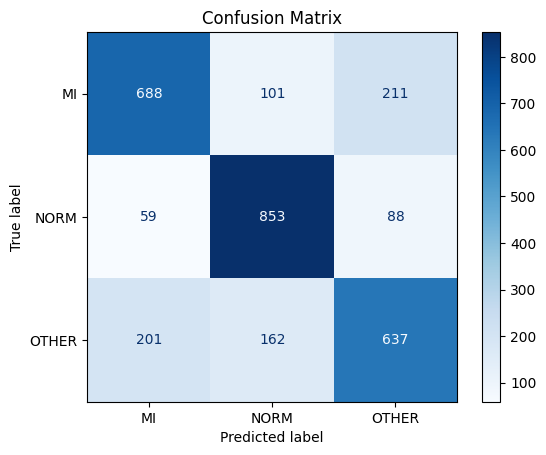

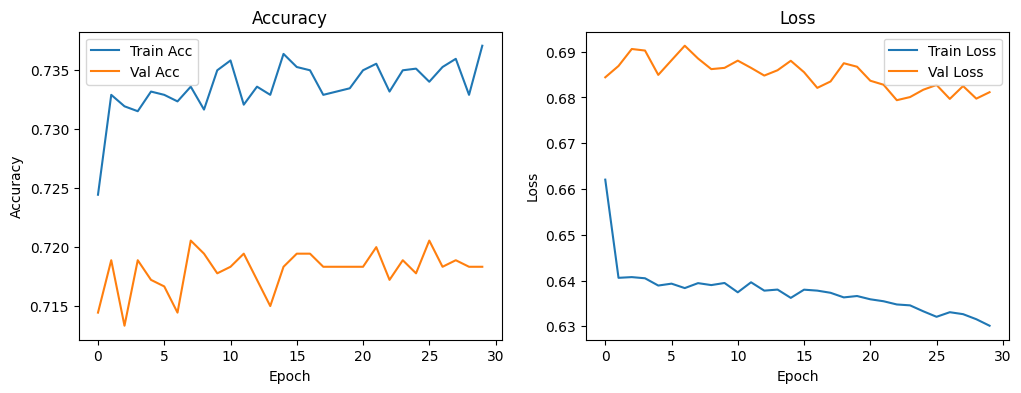

In [18]:
from sklearn.metrics import accuracy_score, classification_report
# Get predictions
X_meta_test = get_meta_features([model1, model2, model3], X_test)
y_pred = np.argmax(meta_model.predict(X_meta_test), axis=1)

from sklearn.metrics import classification_report, accuracy_score

# Convert one-hot to integer labels
y_test_labels = np.argmax(y_test, axis=1)

print("Test Accuracy:", accuracy_score(y_test_labels, y_pred))
print(classification_report(y_test_labels, y_pred, target_names=["AFIB", "NORM", "OTHER"]))

# Step 12: Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["MI", "NORM", "OTHER"]).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Step 13: Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Step 11: Classification Report
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["MI", "NORM", "OTHER"]))

# Step 12: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["MI", "NORM", "OTHER"]).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Step 13: Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
